<a href="https://colab.research.google.com/github/SharlotteManganye/Deep-Learning-CNN/blob/main/PI_CNN_20250205.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


Visualize feature maps on a simple **CNN**

In [ ]:

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=1, shuffle=True)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 451kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.16MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.67MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Visualize feature maps on a simple **CNN**

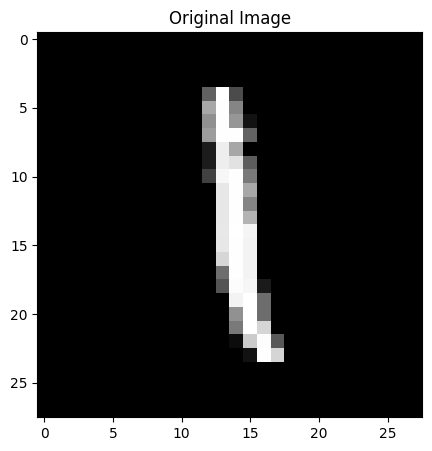

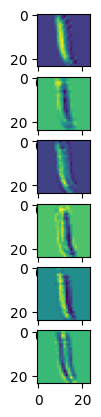

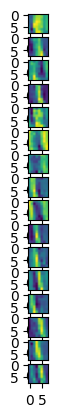

In [ ]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=1, shuffle=True)

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNNModel()

# Register forward hooks
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))

# Pass an image through the model
data_iter = iter(data_loader)
images, labels = next(data_iter)  # Use next() function
output = model(images)

# Visualize the original image
plt.figure(figsize=(5, 5))
plt.imshow(images[0][0], cmap='gray')
plt.title('Original Image')
plt.show()

# Visualize the feature maps
def plot_activation(activation, layer_name):
    act = activation[layer_name].squeeze()
    fig, axarr = plt.subplots(act.size(0))
    for idx in range(act.size(0)):
        axarr[idx].imshow(act[idx])
    plt.show()

plot_activation(activation, 'conv1')
plot_activation(activation, 'conv2')

Visualize feature maps on a simple **PI-CNN**

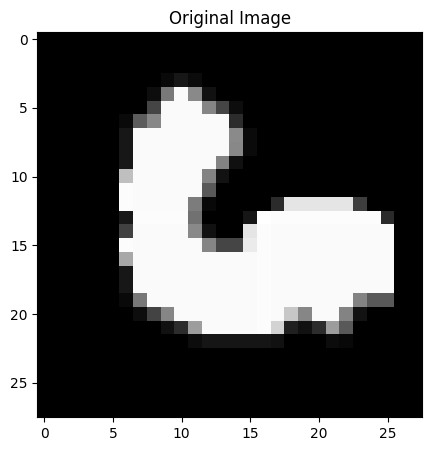

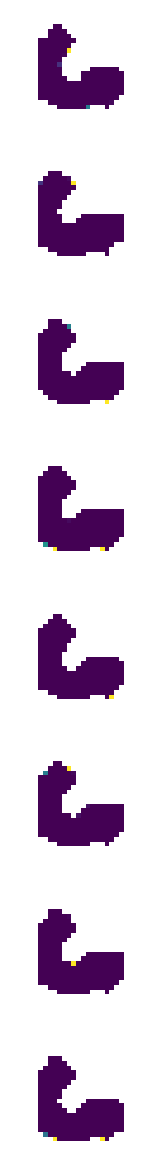

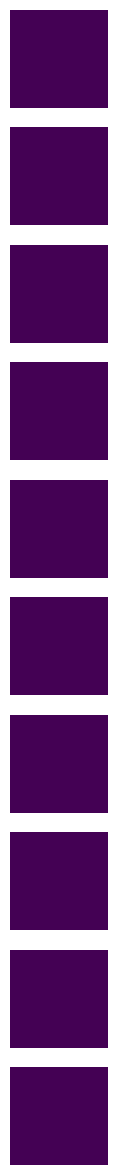

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import math

# Define the ProductConv2d class
class ProductConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(ProductConv2d, self).__init__()
        self.weights = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
        self.stride = stride
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5))

    def forward(self, x):
        unfolded = F.unfold(x, kernel_size=self.weights.shape[2:], stride=self.stride)
        unfolded = unfolded.view(x.size(0), x.size(1) * self.weights.shape[2] * self.weights.shape[3], -1)
        log_unfolded = torch.log(torch.abs(unfolded) + 1e-10)  # Add epsilon to avoid log(0)
        log_weights = torch.log(torch.abs(self.weights) + 1e-10).view(self.weights.size(0), -1)  # Add epsilon to avoid log(0)
        log_product = torch.matmul(log_weights, log_unfolded)
        return torch.exp(log_product).view(x.size(0), self.weights.size(0), x.size(2) - self.weights.shape[2] + 1, x.size(3) - self.weights.shape[3] + 1)

# Define the CombinedCNN class
class CombinedCNN(nn.Module):
    def __init__(self):
        super(CombinedCNN, self).__init__()
        self.product_conv1 = ProductConv2d(1, 8, kernel_size=3)
        self.product_conv2 = ProductConv2d(8, 10, kernel_size=3)
        self.fc1 = nn.Linear(10 * 5 * 5, 120)  # Adjusted input size for fully connected layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.product_conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.product_conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = x.view(-1, 10 * 5 * 5)  # Adjusted input size for fully connected layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# Register forward hooks
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model = CombinedCNN()
model.eval()

model.product_conv1.register_forward_hook(get_activation('product_conv1'))
model.product_conv2.register_forward_hook(get_activation('product_conv2'))

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=1, shuffle=True)

# Get a batch of data
data_iter = iter(data_loader)
images, labels = next(data_iter)

# Forward pass
output = model(images)

# Visualize the original image
plt.figure(figsize=(5, 5))
plt.imshow(images[0][0], cmap='gray')
plt.title('Original Image')
plt.show()

# Function to visualize the feature maps
def plot_activation(activation, layer_name):
    act = activation[layer_name].squeeze()
    fig, axarr = plt.subplots(act.size(0), figsize=(15, 15))
    for idx in range(act.size(0)):
        axarr[idx].imshow(act[idx], cmap='viridis')
        axarr[idx].axis('off')
    plt.show()

# Visualize the feature maps
plot_activation(activation, 'product_conv1')
plot_activation(activation, 'product_conv2')


Visualize feature maps on a simple *** PI-CNN***

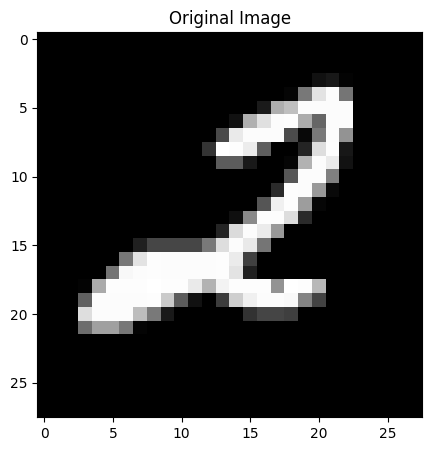

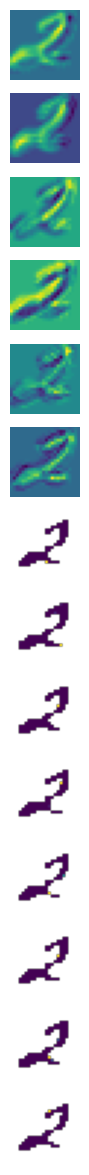

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import math

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the ProductConv2d class
class ProductConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(ProductConv2d, self).__init__()
        self.weights = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
        self.stride = stride
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5))

    def forward(self, x):
        unfolded = F.unfold(x, kernel_size=self.weights.shape[2:], stride=self.stride)
        unfolded = unfolded.view(x.size(0), x.size(1) * self.weights.shape[2] * self.weights.shape[3], -1)
        log_unfolded = torch.log(torch.abs(unfolded) + 1e-10)  # Add epsilon to avoid log(0)
        log_weights = torch.log(torch.abs(self.weights) + 1e-10).view(self.weights.size(0), -1)  # Add epsilon to avoid log(0)
        log_product = torch.matmul(log_weights, log_unfolded)
        return torch.exp(log_product).view(x.size(0), self.weights.size(0), x.size(2) - self.weights.shape[2] + 1, x.size(3) - self.weights.shape[3] + 1)

# Define the CombinedCNN class
class CombinedCNN(nn.Module):
    def __init__(self):
        super(CombinedCNN, self).__init__()
        self.product_conv1 = ProductConv2d(1, 8, kernel_size=3)
        self.product_conv2 = ProductConv2d(8, 10, kernel_size=3)
        self.fc1 = nn.Linear(10 * 5 * 5, 120)  # Adjusted input size for fully connected layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.product_conv1(x)
        # x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.product_conv2(x)
        # x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = x.view(-1, 10 * 5 * 5)  # Adjusted input size for fully connected layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# Register forward hooks
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Instantiate models
model1 = CNNModel()
model2 = CombinedCNN()

model1.conv1.register_forward_hook(get_activation('conv1'))
model2.product_conv1.register_forward_hook(get_activation('product_conv1'))

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=1, shuffle=True)

# Get a batch of data
data_iter = iter(data_loader)
images, labels = next(data_iter)

# Forward pass through both models
output1 = model1(images)
output2 = model2(images)

# Resize feature maps to the same size
conv1_feature_map = activation['conv1']
product_conv1_feature_map = activation['product_conv1']
product_conv1_feature_map_resized = F.interpolate(product_conv1_feature_map, size=conv1_feature_map.shape[2:])

# Stack the feature maps
stacked_feature_maps = torch.cat((conv1_feature_map, product_conv1_feature_map_resized), dim=1)

# Visualize the original image
plt.figure(figsize=(5, 5))
plt.imshow(images[0][0], cmap='gray')
plt.title('Original Image')
plt.show()

# Visualize the stacked feature maps
def plot_stacked_activation(stacked_activation):
    act = stacked_activation.squeeze()
    fig, axarr = plt.subplots(act.size(0), figsize=(15, 15))
    for idx in range(act.size(0)):
        axarr[idx].imshow(act[idx], cmap='viridis')
        axarr[idx].axis('off')
    plt.show()

plot_stacked_activation(stacked_feature_maps)


Visualize feature maps on a simple *** PI-Sigma-CNN***. use product layer as input to standard CNN

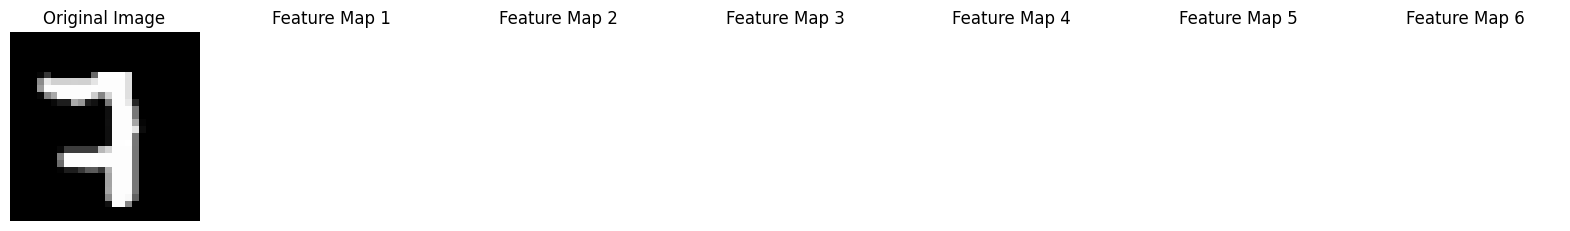

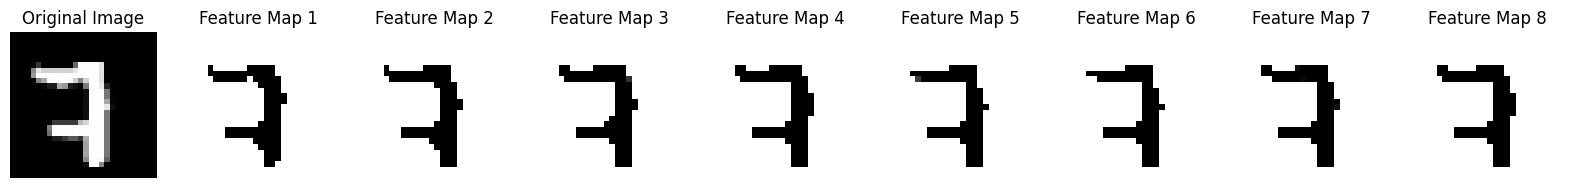

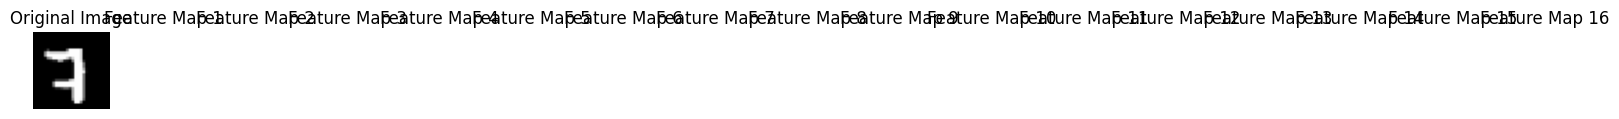

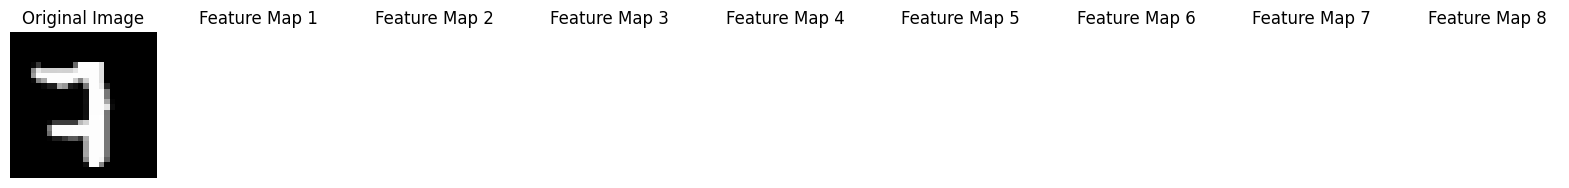

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math

# Define the ProductConv2d class
class ProductConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(ProductConv2d, self).__init__()
        self.weights = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
        self.stride = stride
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5))

    def forward(self, x):
        unfolded = F.unfold(x, kernel_size=self.weights.shape[2:], stride=self.stride)
        unfolded = unfolded.view(x.size(0), x.size(1) * self.weights.shape[2] * self.weights.shape[3], -1)
        log_unfolded = torch.log(torch.abs(unfolded) + 1e-10)  # Add epsilon to avoid log(0)
        log_weights = torch.log(torch.abs(self.weights) + 1e-10).view(self.weights.size(0), -1)  # Add epsilon to avoid log(0)
        log_product = torch.matmul(log_weights, log_unfolded)
        return torch.exp(log_product).view(x.size(0), self.weights.size(0), x.size(2) - self.weights.shape[2] + 1, x.size(3) - self.weights.shape[3] + 1)

# Define the CombinedCNN class
class CombinedCNN(nn.Module):
    def __init__(self):
        super(CombinedCNN, self).__init__()
        self.product_conv1 = ProductConv2d(1, 8, kernel_size=3)
        self.conv1 = nn.Conv2d(8, 6, 3, padding=1)  # Added padding
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)  # Added padding
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)  # Added padding

        # Calculate the correct input size for fc1
        self.fc1_input_size = self._get_fc1_input_size()
        self.fc1 = nn.Linear(self.fc1_input_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # Initialize hooks dictionary
        self.feature_maps = {}

        # Register hooks
        self.product_conv1.register_forward_hook(self.save_feature_maps('product_conv1'))
        self.conv1.register_forward_hook(self.save_feature_maps('conv1'))
        self.conv2.register_forward_hook(self.save_feature_maps('conv2'))
        self.conv3.register_forward_hook(self.save_feature_maps('conv3'))

    def _get_fc1_input_size(self):
        # Create a dummy input tensor with the same size as your input images
        dummy_input = torch.zeros(1, 1, 28, 28)  # Assuming input images are 28x28
        product_conv1 = self.product_conv1(dummy_input)
        product_conv1 = F.relu(product_conv1)
        product_conv1 = F.max_pool2d(product_conv1, 2)

        conv1 = F.relu(self.conv1(product_conv1))
        conv1 = F.max_pool2d(conv1, 2)

        conv2_output = F.relu(self.conv2(conv1))
        conv2_output = F.max_pool2d(conv2_output, 2)

        conv3_output = F.relu(self.conv3(conv2_output))
        return conv3_output.view(1, -1).size(1)

    def save_feature_maps(self, layer_name):
        def hook(module, input, output):
            self.feature_maps[layer_name] = output.detach()
        return hook

    def forward(self, x):
        product_conv1 = self.product_conv1(x)  # Product units layer
        product_conv1 = F.relu(product_conv1)
        product_conv1 = F.max_pool2d(product_conv1, 2)

        conv1 = F.relu(self.conv1(product_conv1))  # Use product_conv1 output as input to conv1
        conv1 = F.max_pool2d(conv1, 2)

        conv2_output = F.relu(self.conv2(conv1))
        conv2_output = F.max_pool2d(conv2_output, 2)

        conv3_output = F.relu(self.conv3(conv2_output))  # Use conv2 output as input to conv3

        conv3_output = conv3_output.view(conv3_output.size(0), -1)  # Flatten the tensor
        conv3_output = F.relu(self.fc1(conv3_output))
        conv3_output = F.relu(self.fc2(conv3_output))
        output1 = self.fc3(conv3_output)

        return output1

    def plot_feature_maps(self, layer_name, original_image):
        feature_maps = self.feature_maps[layer_name]
        num_maps = feature_maps.shape[1]

        fig, axes = plt.subplots(1, num_maps + 1, figsize=(20, 20))

        # Plot original image
        axes[0].imshow(original_image.squeeze().cpu(), cmap='gray')
        axes[0].axis('off')
        axes[0].set_title('Original Image')

        for i in range(num_maps):
            axes[i + 1].imshow(feature_maps[0, i].cpu(), cmap='gray')
            axes[i + 1].axis('off')
            axes[i + 1].set_title(f'Feature Map {i+1}')
        plt.show()

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=1, shuffle=True)

# Example usage
model = CombinedCNN()
data_iter = iter(data_loader)
images, labels = next(data_iter)  # Use next() function correctly
output = model(images)

# Plot feature maps for conv1, product_conv1, conv2, and conv3 along with the original image
model.plot_feature_maps('conv1', images[0])
model.plot_feature_maps('product_conv1', images[0])
model.plot_feature_maps('conv2', images[0])
model.plot_feature_maps('conv3', images[0])


Visualize feature maps on a simple **PI-Sigma-CNN**. Concatinate results from product layer and standard layer and use as input to next layer


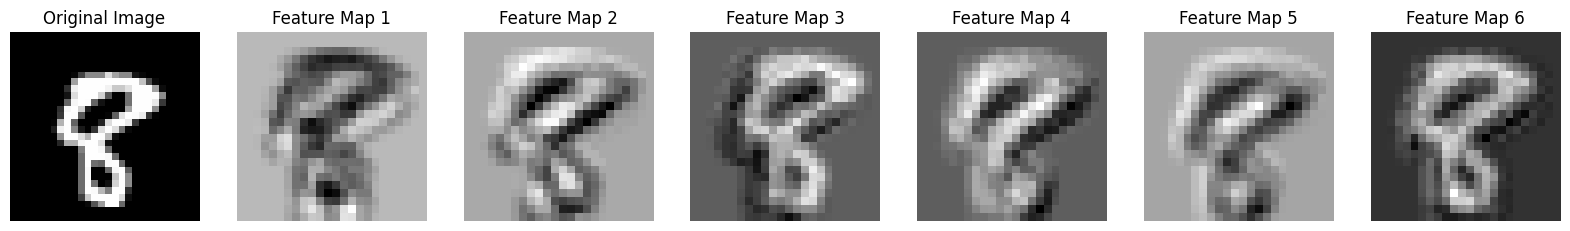

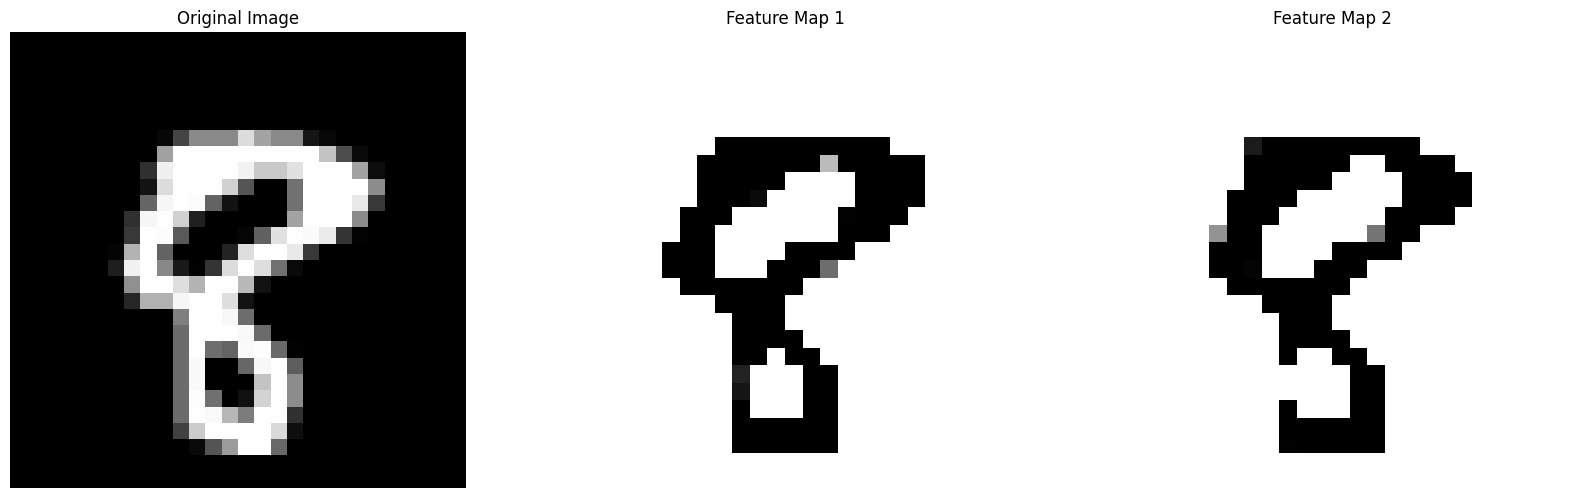

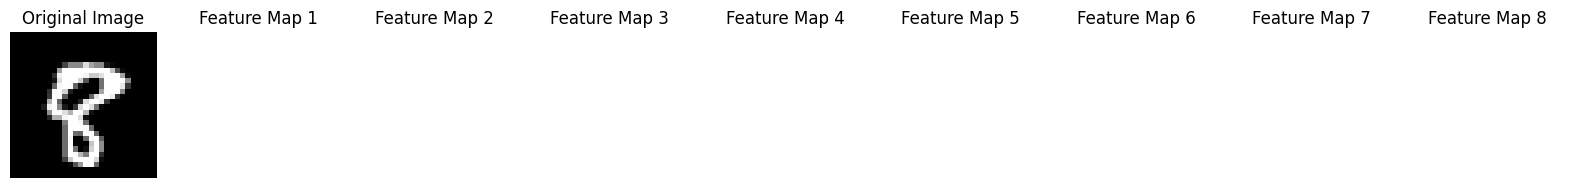

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math

# Define the ProductConv2d class
class ProductConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(ProductConv2d, self).__init__()
        self.weights = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
        self.stride = stride
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5))

    def forward(self, x):
        unfolded = F.unfold(x, kernel_size=self.weights.shape[2:], stride=self.stride)
        unfolded = unfolded.view(x.size(0), -1, unfolded.size(-1))
        log_unfolded = torch.log(torch.abs(unfolded) + 1e-10)  # Add epsilon to avoid log(0)
        log_weights = torch.log(torch.abs(self.weights) + 1e-10).view(self.weights.size(0), -1)  # Add epsilon to avoid log(0)
        log_product = torch.matmul(log_weights, log_unfolded)
        return torch.exp(log_product).view(x.size(0), self.weights.size(0), x.size(2) - self.weights.shape[2] + 1, x.size(3) - self.weights.shape[3] + 1)

# Define the CombinedCNN class
class CombinedCNN(nn.Module):
    def __init__(self):
        super(CombinedCNN, self).__init__()
        self.product_conv1 = ProductConv2d(1, 2, kernel_size=3)
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3)  # Adjusted input channels to match concatenated feature maps
        self.conv3 = nn.Conv2d(16, 8, 3)  # Changed output channels to 8

        # Calculate the correct input size for fc1
        self.fc1_input_size = self._get_fc1_input_size()
        self.fc1 = nn.Linear(self.fc1_input_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # Initialize hooks dictionary
        self.feature_maps = {}

        # Register hooks
        self.product_conv1.register_forward_hook(self.save_feature_maps('product_conv1'))
        self.conv1.register_forward_hook(self.save_feature_maps('conv1'))
        self.conv2.register_forward_hook(self.save_feature_maps('conv2'))
        self.conv3.register_forward_hook(self.save_feature_maps('conv3'))

    def _get_fc1_input_size(self):
        # Create a dummy input tensor with the same size as your input images
        dummy_input = torch.zeros(1, 1, 28, 28)  # Assuming input images are 28x28
        y = self.product_conv1(dummy_input)
        y = F.relu(y)
        y = F.max_pool2d(y, 2)

        z = F.relu(self.conv1(dummy_input))
        z = self.pool(z)

        if y.size(2) != z.size(2) or y.size(3) != z.size(3):
            z = F.interpolate(z, size=(y.size(2), y.size(3)))

        new_inputs = torch.cat((y, z), dim=1)
        conv2_output = self.pool(self.conv2(new_inputs))
        conv3_output = self.pool(self.conv3(conv2_output))
        return conv3_output.view(1, -1).size(1)

    def save_feature_maps(self, layer_name):
        def hook(module, input, output):
            self.feature_maps[layer_name] = output.detach()
        return hook

    def forward(self, x):
        y = self.product_conv1(x)  # Product units layer
        y = F.relu(y)
        y = F.max_pool2d(y, 2)

        z = F.relu(self.conv1(x))  # Sigma layer
        z = self.pool(z)

        if y.size(2) != z.size(2) or y.size(3) != z.size(3):
            z = F.interpolate(z, size=(y.size(2), y.size(3)))

        # Concatenate feature maps from conv1 and product_conv1
        combined_inputs = torch.cat((y, z), dim=1)
        conv2_output = self.pool(self.conv2(combined_inputs))

        # Use feature maps from conv2 as input to conv3
        conv3_output =  self.pool(self.conv3(conv2_output))
        conv3_output = conv3_output.view(conv3_output.size(0), -1)  # Flatten the tensor
        conv3_output = F.softmax(self.fc1(conv3_output), dim=1)
        conv3_output = F.softmax(self.fc2(conv3_output), dim=1)
        output1 = self.fc3(conv3_output)

        return output1

    def plot_feature_maps(self, layer_name, original_image):
        feature_maps = self.feature_maps[layer_name]
        num_maps = feature_maps.shape[1]

        fig, axes = plt.subplots(1, num_maps + 1, figsize=(20, 20))

        # Plot original image
        axes[0].imshow(original_image.squeeze().cpu(), cmap='gray')
        axes[0].axis('off')
        axes[0].set_title('Original Image')

        for i in range(num_maps):
            axes[i + 1].imshow(feature_maps[0, i].cpu(), cmap='gray')
            axes[i + 1].axis('off')
            axes[i + 1].set_title(f'Feature Map {i+1}')
        plt.show()

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=1, shuffle=True)

# Example usage
model = CombinedCNN()
data_iter = iter(data_loader)
images, labels = next(data_iter)  # Use next() function correctly
output = model(images)

# Plot feature maps for conv1, product_conv1, and conv3 along with the original image
model.plot_feature_maps('conv1', images[0])
model.plot_feature_maps('product_conv1', images[0])
model.plot_feature_maps('conv3', images[0])


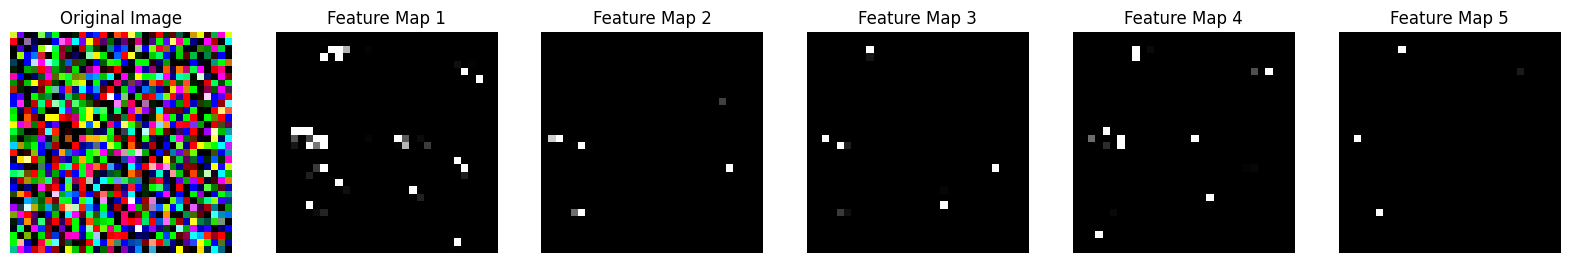

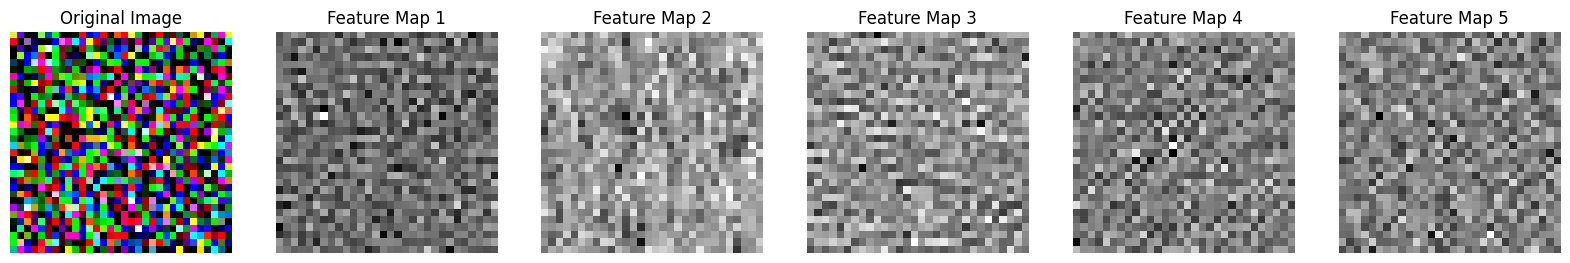

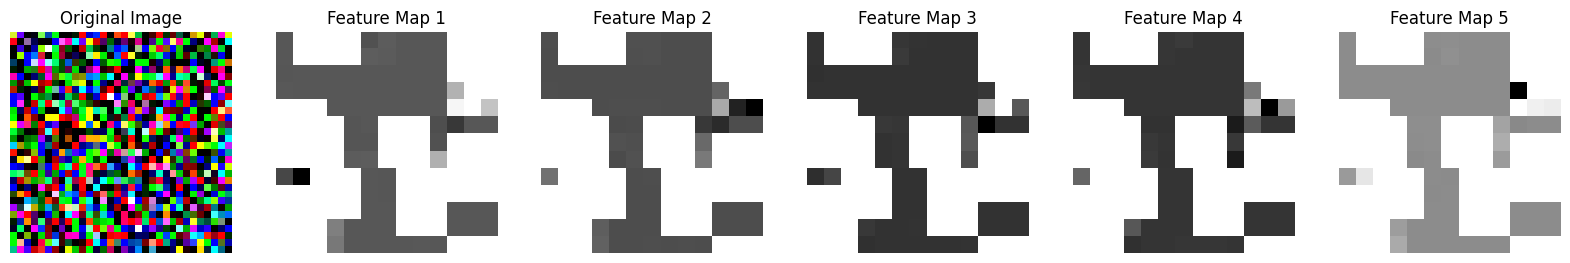

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math

# Define the ProductConv2d class
class ProductConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(ProductConv2d, self).__init__()
        self.weights = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
        self.stride = stride
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5))

    def forward(self, x):
        unfolded = F.unfold(x, kernel_size=self.weights.shape[2:], stride=self.stride)
        unfolded = unfolded.view(x.size(0), -1, unfolded.size(-1))
        log_unfolded = torch.log(torch.abs(unfolded) + 1e-10)  # Add epsilon to avoid log(0)
        log_weights = torch.log(torch.abs(self.weights) + 1e-10).view(self.weights.size(0), -1)  # Add epsilon to avoid log(0)
        log_product = torch.matmul(log_weights, log_unfolded)
        return torch.exp(log_product).view(x.size(0), self.weights.size(0), x.size(2) - self.weights.shape[2] + 1, x.size(3) - self.weights.shape[3] + 1)

# Define the CombinedCNN class
class CombinedCNN(nn.Module):
    def __init__(self):
        super(CombinedCNN, self).__init__()
        self.product_conv1 = ProductConv2d(3, 5, kernel_size=3)  # 5 output channels
        self.conv1 = nn.Conv2d(3, 5, 3, 1)  # 5 output channels
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 5, 3, 1)  # 5 output channels, adjusted input channels to match concatenated feature maps
        self.fc1 = nn.Linear(5 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, 10)  # Assuming 10 classes for classification

        # Initialize hooks dictionary
        self.feature_maps = {}

        # Register hooks
        self.product_conv1.register_forward_hook(self.save_feature_maps('product_conv1'))
        self.conv1.register_forward_hook(self.save_feature_maps('conv1'))
        self.conv2.register_forward_hook(self.save_feature_maps('conv2'))

    def save_feature_maps(self, layer_name):
        def hook(module, input, output):
            self.feature_maps[layer_name] = output.detach()
        return hook

    def forward(self, x):
        y = self.product_conv1(x)  # Product units layer
        y = F.relu(y)
        y = self.pool(y)

        z = F.relu(self.conv1(x))  # Standard CNN layer
        z = self.pool(z)

        if y.size(2) != z.size(2) or y.size(3) != z.size(3):
            z = F.interpolate(z, size=(y.size(2), y.size(3)))

        # Concatenate feature maps from conv1 and product_conv1
        combined_features = torch.cat((y, z), dim=1)
        combined_features = F.relu(self.conv2(combined_features))
        combined_features = self.pool(combined_features)
        combined_features = combined_features.view(combined_features.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(combined_features))
        x = self.fc2(x)
        return x

    def plot_feature_maps(self, layer_name, original_image):
        feature_maps = self.feature_maps[layer_name]
        num_maps = feature_maps.shape[1]

        fig, axes = plt.subplots(1, num_maps + 1, figsize=(20, 20))

        # Plot original image
        axes[0].imshow(original_image.squeeze().cpu().permute(1, 2, 0))
        axes[0].axis('off')
        axes[0].set_title('Original Image')

        for i in range(num_maps):
            axes[i + 1].imshow(feature_maps[0, i].cpu(), cmap='gray')
            axes[i + 1].axis('off')
            axes[i + 1].set_title(f'Feature Map {i+1}')
        plt.show()

# Example usage
transform = transforms.Compose([transforms.ToTensor()])
input_image = torch.randn(1, 3, 32, 32)  # Dummy input

model = CombinedCNN()
output = model(input_image)

# Plot feature maps for product_conv1, conv1, and conv2 along with the original image
model.plot_feature_maps('product_conv1', input_image)
model.plot_feature_maps('conv1', input_image)
model.plot_feature_maps('conv2', input_image)


**replace zeros with minus -5**


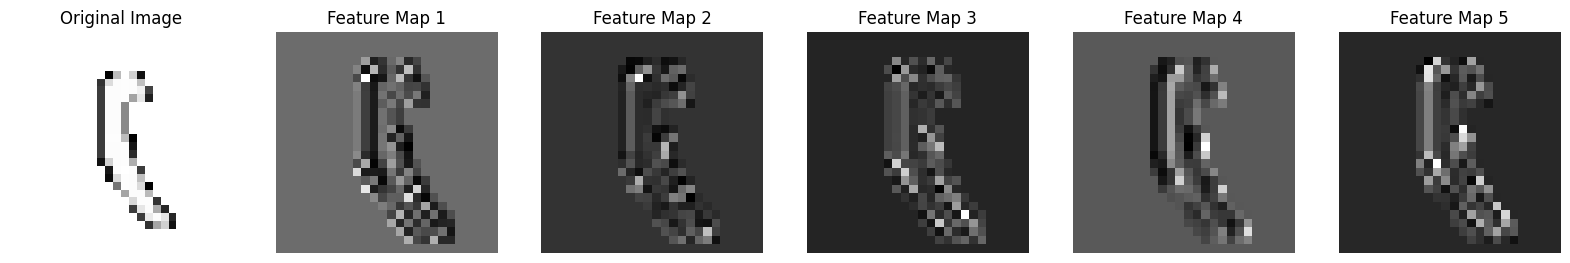

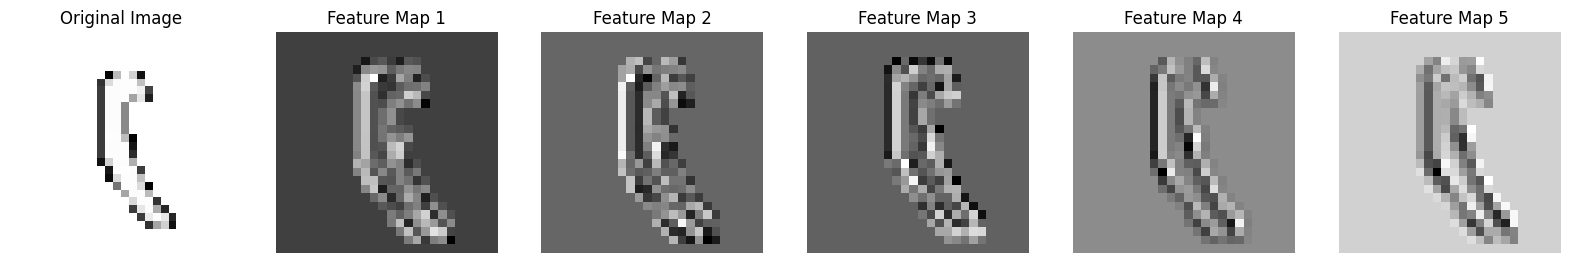

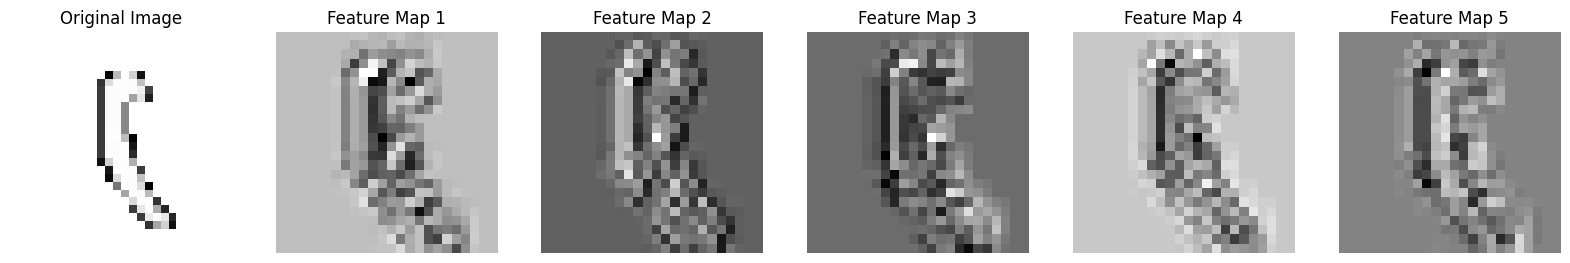

In [27]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# Enable anomaly detection
# torch.autograd.set_detect_anomaly(True)

class ProductConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(ProductConv2d, self).__init__()
        self.weights_u = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)) # for positive inputs
        self.weights_v = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)) # for indicator function
        self.stride = stride
        # Initialize weights (important!)
        nn.init.kaiming_uniform_(self.weights_u, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.weights_v, a=math.sqrt(5))

    def forward(self, x):
        batch_size, in_channels, in_height, in_width = x.size()
        kernel_size = self.weights_u.shape[2]
        out_channels = self.weights_u.shape[0]

        out_height = (in_height - kernel_size) // self.stride + 1
        out_width = (in_width - kernel_size) // self.stride + 1

        # Unfold the input tensor
        unfolded = F.unfold(x, kernel_size=kernel_size, stride=self.stride)
        unfolded = unfolded.view(batch_size, in_channels * kernel_size * kernel_size, out_height * out_width)

        # Weights for positive input component
        weights_u_reshaped = self.weights_u.view(out_channels, -1)

        # Logarithm of absolute value
        log_abs_unfolded = torch.log(torch.abs(unfolded) + 1e-10)  # Add small constant for numerical stability

        # Compute the exponential part (corresponding to Eq. 3)
        exp_term = torch.exp(torch.einsum("oc,bcp->bop", weights_u_reshaped, log_abs_unfolded))

        # Weights for indicator function
        weights_v_reshaped = self.weights_v.view(out_channels, -1)

        # Indicator function (vectorized)
        indicator = (unfolded < 0).float()

        # Compute the cosine term (corresponding to Eq. 4)
        cosine_term = torch.cos(math.pi * torch.einsum("oc,bcp->bop", weights_v_reshaped, indicator)).view(batch_size, out_channels, out_height, out_width)

        # Combine the terms
        output = exp_term.view(batch_size, out_channels, out_height, out_width) * cosine_term

        return output

# Define the CombinedCNN class
class CombinedCNN(nn.Module):
    def __init__(self):
        super(CombinedCNN, self).__init__()
        self.product_conv1 = ProductConv2d(1, 5, kernel_size=3)  # 5 output channels, 1 input channel for MNIST
        self.conv1 = nn.Conv2d(1, 5, 3, 1)  # 5 output channels, 1 input channel for MNIST
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 5, 3, 1)  # 5 output channels, adjusted input channels to match concatenated feature maps
        self.conv3 = nn.Conv2d(5, 5, 3, 1)  # New conv3 layer with 10 output channels

        # Calculate the size of the input to the first fully connected layer
        self.fc_input_size = self._get_fc_input_size()

        self.fc1 = nn.Linear(self.fc_input_size, 128)  # Adjusted input size for MNIST
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST

        # Initialize hooks dictionary
        self.feature_maps = {}

        # Register hooks
        self.product_conv1.register_forward_hook(self.save_feature_maps('product_conv1'))
        self.conv1.register_forward_hook(self.save_feature_maps('conv1'))
        self.conv2.register_forward_hook(self.save_feature_maps('conv2'))
        # self.conv3.register_forward_hook(self.save_feature_maps('conv3'))

    def _get_fc_input_size(self):
        # Create a dummy tensor with the same shape as the input
        dummy_input = torch.zeros(1, 1, 28, 28)
        # Pass the dummy tensor through the convolutional layers
        y = self.product_conv1(dummy_input)
        y = F.tanh(y)
        # y = self.pool(y)
        z = F.relu(self.conv1(dummy_input))
        z = self.pool(z)
        if y.size(2) != z.size(2) or y.size(3) != z.size(3):
            z = F.interpolate(z, size=(y.size(2), y.size(3)))
        combined_features = torch.cat((y, z), dim=1)
        combined_features = F.tanh(self.conv2(combined_features))
        # combined_features = self.pool(combined_features)
        # combined_features = F.relu(self.conv3(combined_features))
        combined_features = self.pool(combined_features)
        # Flatten the tensor and return the size
        return combined_features.view(1, -1).size(1)

    def save_feature_maps(self, layer_name):
        def hook(module, input, output):
            self.feature_maps[layer_name] = output.detach()
        return hook

    def forward(self, x):
        y = self.product_conv1(x)  # Product units layer
        if torch.isnan(y).any():
            print("NaN detected in product_conv1 output")
        y = F.tanh(y)

        z = F.relu(self.conv1(x))  # Standard CNN layer
        if torch.isnan(z).any():
            print("NaN detected in conv1 output")
        z = self.pool(z)

        if y.size(2) != z.size(2) or y.size(3) != z.size(3):
            z = F.interpolate(z, size=(y.size(2), y.size(3)))

        # Concatenate feature maps from conv1 and product_conv1
        combined_features = torch.cat((y, z), dim=1)
        combined_features = F.tanh(self.conv2(combined_features))

        if torch.isnan(combined_features).any():
            print("NaN detected in conv2 output")

        combined_features = self.pool(combined_features)

        combined_features = combined_features.view(combined_features.size(0), -1)  # Flatten the tensor

        x = F.relu(self.fc1(combined_features))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

    def plot_feature_maps(self, layer_name, original_image):
        feature_maps = self.feature_maps[layer_name]
        num_maps = feature_maps.shape[1]

        fig, axes = plt.subplots(1, num_maps + 1, figsize=(20, 20))

        # Plot original image
        # Select the first image from the batch and move to cpu
        axes[0].imshow(original_image[0].squeeze().cpu(), cmap='gray')
        axes[0].axis('off')
        axes[0].set_title('Original Image')

        for i in range(num_maps):
            axes[i + 1].imshow(feature_maps[0, i].cpu(), cmap='gray')
            axes[i + 1].axis('off')
            axes[i + 1].set_title(f'Feature Map {i+1}')
        plt.show()

class MNISTNoZeros(Dataset):
    def __init__(self, root, train=True, transform=None, download=False):
        self.dataset = datasets.MNIST(root=root, train=train, transform=transform, download=download)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        # Convert the image to a tensor
        image = transforms.ToTensor()(image)
        # Replace zeros with -5
        image = torch.where(image == 0, torch.tensor(1.0), image)
        if self.transform:
            image = self.transform(image)
        return image, label

# Define any additional transforms you need (excluding ToTensor)
transform = transforms.Compose([
    # Add any other transforms here
])

# Load the MNIST dataset without zeros
train_data = MNISTNoZeros(root='data', train=True, transform=transform, download=True)
test_data = MNISTNoZeros(root='data', train=False, transform=transform)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1)
test_loader = DataLoader(test_data, batch_size=100, shuffle=False, num_workers=1)


# Example usage
model = CombinedCNN()
data_iter = iter(train_loader)
images, labels = next(data_iter)
output = model(images)

# Plot feature maps for product_conv1, conv1, and conv2 along with the original image
model.plot_feature_maps('product_conv1', images)
model.plot_feature_maps('conv1', images)
model.plot_feature_maps('conv2', images)


In [28]:

model =CombinedCNN()
# loss function
loss_func = nn.CrossEntropyLoss()
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

def train(epoch):

    # Setting model in training mode.
    model.train()

    train_loss = 0
    train_acc = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        #clear gradient
        optimizer.zero_grad()

        #FP (make a prediction)
        output = model(data.float())

        # calculating the loss
        loss = loss_func(output, target)

        #BP, Computing the gradient of the loss w.r.t the parameters of the model
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # a single step of optimization, update parameters
        optimizer.step()

        train_loss += loss.item()

        _, pred = output.max(1)
        train_acc += target.eq(pred).sum().item()

    train_acc /= len(train_loader.dataset)
    train_loss /= (batch_idx + 1) # Average per batch

    return train_loss, train_acc




In [29]:
   def val():
    # setting model in evaluation mode.
    model.eval()

    val_loss = 0
    val_acc = 0

    # no gradient is needed
    # when calling a PyTorch neural network to compute output during TRAINING, you should NEVER use the no_grad() statement,
    # but when NOT TRAINING, using the no_grad() statement is optional but more principled.
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):

            #FP
            output = model(data.float())

            # loss
            val_loss += loss_func(output, target).item()
            _, pred = output.max(1)
            val_acc += target.eq(pred).sum().item()

    val_loss /= (batch_idx + 1) # Average per batch
    val_acc /= len(test_loader.dataset)
    return val_loss, val_acc


loss_list = []
val_loss_list = []

acc_list = []
val_acc_list = []

epochs = 10
for epoch in range(1, epochs + 1):
    print("--- Epoch {} ---".format(epoch))

    train_loss, train_acc = train(epoch)
    print('\tTrain loss: {:.4f}, acc: {:.4f}%'.format(train_loss, train_acc))
    loss_list.append(train_loss)
    acc_list.append(train_acc)

    val_loss, val_acc =  val()
    print('\tVal loss: {:.4f}, acc: {:.4f}%'.format(val_loss, val_acc))
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)


--- Epoch 1 ---
	Train loss: 2.1508, acc: 0.3255%
	Val loss: 1.8997, acc: 0.6272%
--- Epoch 2 ---
	Train loss: 1.8426, acc: 0.6489%
	Val loss: 1.8059, acc: 0.6734%
--- Epoch 3 ---
	Train loss: 1.7750, acc: 0.7090%
	Val loss: 1.7137, acc: 0.7760%
--- Epoch 4 ---
	Train loss: 1.6950, acc: 0.7896%
	Val loss: 1.6711, acc: 0.8078%
--- Epoch 5 ---
	Train loss: 1.6661, acc: 0.8129%
	Val loss: 1.6511, acc: 0.8275%
--- Epoch 6 ---
	Train loss: 1.6494, acc: 0.8269%
	Val loss: 1.6389, acc: 0.8375%
--- Epoch 7 ---
	Train loss: 1.6374, acc: 0.8371%
	Val loss: 1.6292, acc: 0.8462%
--- Epoch 8 ---
	Train loss: 1.6273, acc: 0.8471%
	Val loss: 1.6241, acc: 0.8493%
--- Epoch 9 ---
	Train loss: 1.6186, acc: 0.8545%
	Val loss: 1.6144, acc: 0.8618%
--- Epoch 10 ---
	Train loss: 1.6106, acc: 0.8618%
	Val loss: 1.6064, acc: 0.8663%


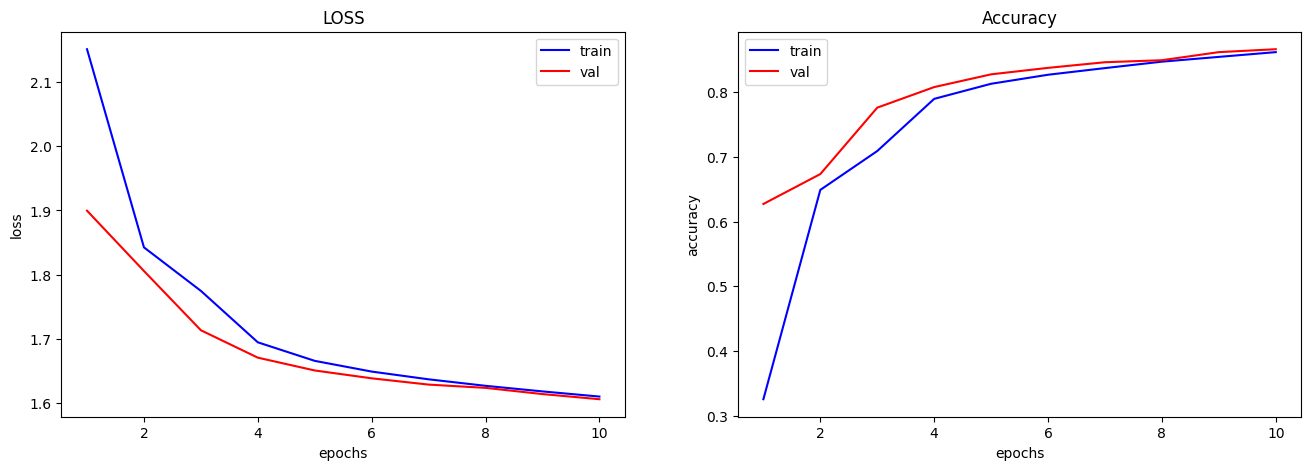

In [30]:
# plot


x = range(1, epochs + 1)

plt.figure(figsize=(16, 5))

#loss
plt.subplot(1,2,1)
plt.plot(x, loss_list, 'b', label = 'train')
plt.plot(x, val_loss_list, 'r', label = 'val')
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#Accuracy
plt.subplot(1,2,2)
plt.plot(x, acc_list, 'b', label = 'train')
plt.plot(x, val_acc_list, 'r', label = 'val')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()